In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders
#Mel-spectrogram이 있는 사진경로,output:train/test/val 지정 경로
splitfolders.ratio(r'/content/drive/MyDrive/Colab Notebooks/dataset/bit 변환/Data(melspectrogram)', output=r'/content/C:\Users\USER\Untitled Folder\Data/', seed=1337, ratio=(0.8, 0.1, 0.1))
import numpy as np
import pandas as pd
from sklearn.utils.multiclass import unique_labels
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import Sequential
from keras.applications.resnet import ResNet50 #For Transfer Learning
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD,Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from tensorflow.keras.utils import to_categorical

#batch size 할당
batch_size=25
test_batch_size=32 
test_steps=1

#train/test/val 지정 경로
train_path = r'/content/C:\Users\USER\Untitled Folder\Data/train'
test_path = r'/content/C:\Users\USER\Untitled Folder\Data/test'
val_path = r'/content/C:\Users\USER\Untitled Folder\Data/val'
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

#ImgaeDataGenerator
def scalar(img):    
    return img  # EfficientNet expects pixelsin range 0 to 255 so no scaling is required
trgen=ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
tvgen=ImageDataGenerator(preprocessing_function=scalar)

#각각 generator
train_generator=trgen.flow_from_directory( directory=train_path , target_size=(224,224), class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
test_generator=tvgen.flow_from_directory( directory=test_path, target_size=(224,224), class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

valid_generator=tvgen.flow_from_directory( directory=val_path, target_size=(224,224), class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

#class 지정
classes=list(train_generator.class_indices.keys())
class_count=len(classes)

#train steps 지정
train_steps=int(np.ceil(len(train_generator.labels)/batch_size))




Copying files: 529 files [02:14,  3.94 files/s]


test batch size:  32   test steps:  1
Found 411 images belonging to 28 classes.
Found 78 images belonging to 28 classes.
Found 40 images belonging to 28 classes.


In [ ]:
lrr= ReduceLROnPlateau(monitor='val_acc', factor=.01, patience=3, min_lr=1e-5)
base_model = ResNet50(include_top = False, weights = 'imagenet', input_shape = (224,224,3), classes = 28)


94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
import tensorflow as tf

In [ ]:
#ResNet model
model= Sequential()
model.add(base_model) 
model.add(Flatten()) 
model.add(Dense(1024,activation=('relu'),input_dim=512))
model.add(Dense(512,activation=('relu'))) 
model.add(Dense(256,activation=('relu'))) 
model.add(Dropout(.3))
model.add(Dense(128,activation=('relu')))
#model.add(Dropout(.2))
model.add(Dense(28,activation=('softmax'))) 

#Checking the final model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 1024)              102761472 
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               3

In [ ]:
#lr/sgd/adam지정
learn_rate=.001
sgd=SGD(learning_rate=learn_rate,momentum=.9,nesterov=False)
adam=Adam(learning_rate=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

#loss지정하여 model compile
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history=model.fit(train_generator,epochs = 10, validation_data = valid_generator, verbose = 1)

Epoch 1/10
17/17 [==============================] - 31s 452ms/step - loss: 3.2062 - accuracy: 0.1971 - val_loss: 2.6174 - val_accuracy: 0.2250
Epoch 2/10
17/17 [==============================] - 5s 287ms/step - loss: 2.1550 - accuracy: 0.4063 - val_loss: 1.9406 - val_accuracy: 0.3750
Epoch 3/10
17/17 [==============================] - 5s 288ms/step - loss: 1.7845 - accuracy: 0.5085 - val_loss: 2.0046 - val_accuracy: 0.4250
Epoch 4/10
17/17 [==============================] - 5s 289ms/step - loss: 1.5574 - accuracy: 0.5474 - val_loss: 1.8737 - val_accuracy: 0.4000
Epoch 5/10
17/17 [==============================] - 5s 298ms/step - loss: 1.0920 - accuracy: 0.6910 - val_loss: 1.6297 - val_accuracy: 0.4750
Epoch 6/10
17/17 [==============================] - 5s 293ms/step - loss: 1.0548 - accuracy: 0.7105 - val_loss: 1.5036 - val_accuracy: 0.6000
Epoch 7/10
17/17 [==============================] - 5s 293ms/step - loss: 0.7134 - accuracy: 0.7859 - val_loss: 0.9305 - val_accuracy: 0.7500
Epoch

In [ ]:
#test(loss/validation)
model.evaluate(test_generator)

3/3 [==============================] - 2s 349ms/step - loss: 2.4551 - accuracy: 0.5256


[2.4550955295562744, 0.5256410241127014]

Minimum Validation Loss: 0.9305


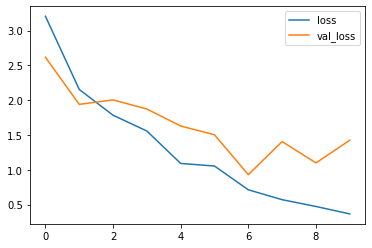

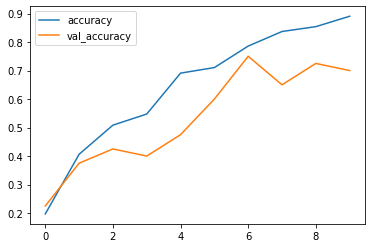

In [ ]:
#Overfitting검사
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
history_df.loc[0:, ['accuracy', 'val_accuracy']].plot()

print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

In [ ]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names     
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)         
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)
    
    
    
   

In [ ]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

          Filename                Predicted Class                True Class           Probability   

 가구끄는 소리/mel200.jpg        어른 발걸음              가구끄는 소리           0.8724

     강아지/mel333.jpg           어른 발걸음                 강아지               0.4083

      골프/mel466.jpg       화장실 물 내리는 소리             골프                0.5680

      골프/mel468.jpg            문 여닫는소리                 골프                0.8453

  굴착기땅파/mel400.jpg         식기 세척기               굴착기땅파            0.9045

  굴착기땅파/mel402.jpg   브레이커의 암석파쇄소리         굴착기땅파            0.2869

       기타/mel2.jpg                런닝머신                     기타                0.4817

       기타/mel5.jpg                  강아지                       기타                0.9972

      기타/mel524.jpg             문 여닫는소리                  기타                0.9472

      기타/mel527.jpg        화장

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4352 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4449 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4462 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4353 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4467 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4354 missing from current font.
  font.set_text(s

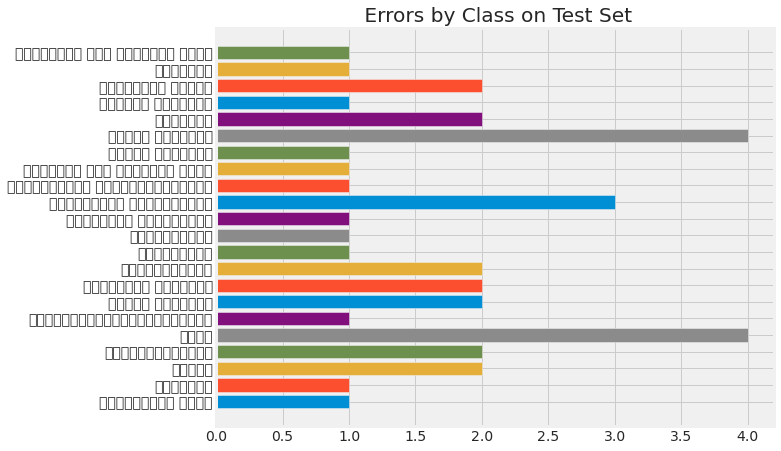

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4455 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4526 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4466 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4456 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 4455 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 4526 missing from current font.
  font.set_text(s, 

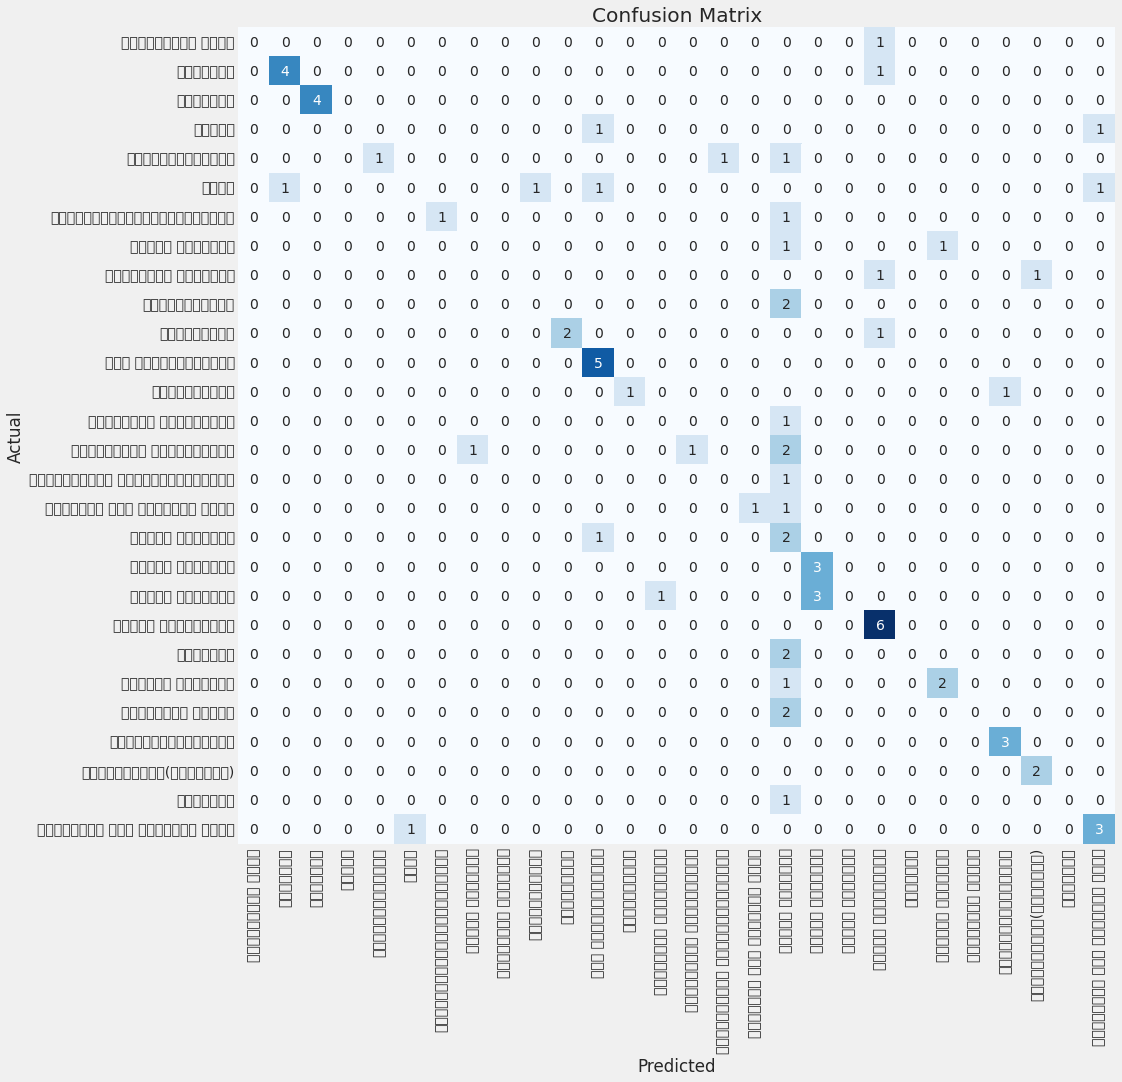

Classification Report:
----------------------
                            precision    recall  f1-score   support

           가구끄는 소리       0.00      0.00      0.00         1
                  강아지       0.80      0.80      0.80         5
                  고양이       1.00      1.00      1.00         4
                    골프       0.00      0.00      0.00         2
            굴착기땅파       1.00      0.33      0.50         3
                     기타       0.00      0.00      0.00         4
   덤프트럭의엔진소리       1.00      0.50      0.67         2
            드럼 세탁기       0.00      0.00      0.00         2
         등하원 아이들       0.00      0.00      0.00         2
              런닝머신       0.00      0.00      0.00         2
                망치소리       1.00      0.67      0.80         3
         문 여닫는소리       0.62      1.00      0.77         5
               바이올린       1.00      0.50      0.67         2
       발전ᄀ

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
p = model.predict(test_generator)
print_info( test_generator, p, 10, r'./', 'MultiDisease' )  